In [ ]:
import librosa
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [ ]:
# Load audio file
audio_path = r"dataset\1-118559-A-17.wav"

Loud Segments (start, end in seconds):
2.00 - 3.00


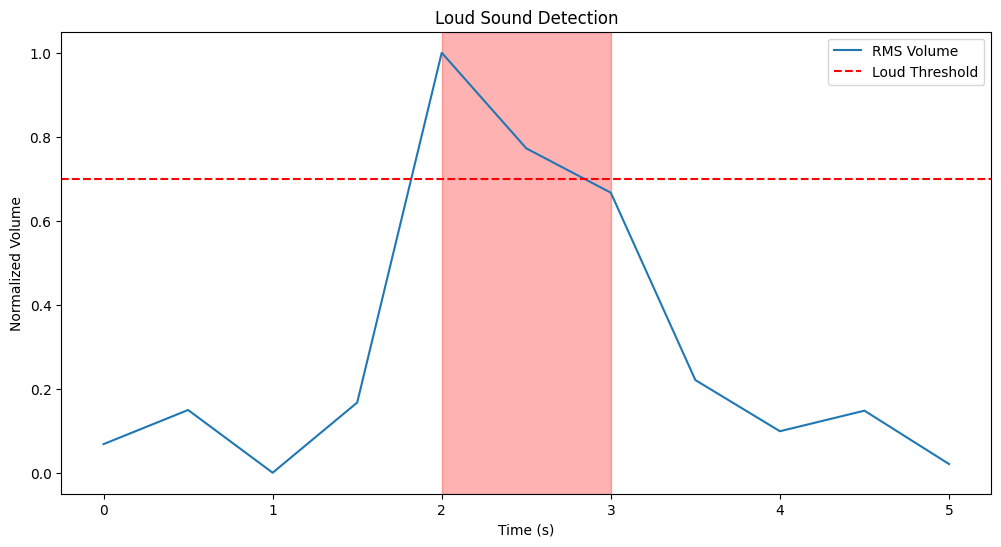

In [ ]:
y, sr = librosa.load(audio_path, sr=None)  # y=audio samples, sr=sample rate

# Parameters
window_size = 0.5  # seconds
hop_length = int(sr * window_size)
frame_length = hop_length

# Extract RMS (volume) per window
rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=hop_length)

# Normalize RMS to [0, 1]
rms_norm = (rms - np.min(rms)) / (np.max(rms) - np.min(rms))

# ===== Mamdani Fuzzy System =====
# Input: Normalized RMS volume
volume = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'volume')
volume['quiet'] = fuzz.trimf(volume.universe, [0, 0, 0.5])
volume['moderate'] = fuzz.trimf(volume.universe, [0.3, 0.5, 0.7])
volume['loud'] = fuzz.trimf(volume.universe, [0.6, 1, 1])

# Output: Loudness probability (0-1)
loudness = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'loudness')
loudness['low'] = fuzz.trimf(loudness.universe, [0, 0, 0.3])
loudness['medium'] = fuzz.trimf(loudness.universe, [0.2, 0.5, 0.8])
loudness['high'] = fuzz.trimf(loudness.universe, [0.7, 1, 1])

# Rules
rule1 = ctrl.Rule(volume['quiet'], loudness['low'])
rule2 = ctrl.Rule(volume['moderate'], loudness['medium'])
rule3 = ctrl.Rule(volume['loud'], loudness['high'])

# Control system
loudness_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
loudness_sim = ctrl.ControlSystemSimulation(loudness_ctrl)

# Process each window
loud_segments = []
is_loud = False
start_time = 0

for i in range(len(rms_norm)):
    loudness_sim.input['volume'] = rms_norm[i]
    loudness_sim.compute()
    loud_prob = loudness_sim.output['loudness']
    
    # Detect loud segments (threshold = 0.7)
    if loud_prob >= 0.7 and not is_loud:
        start_time = times[i]
        is_loud = True
    elif loud_prob < 0.7 and is_loud:
        end_time = times[i]
        loud_segments.append((start_time, end_time))
        is_loud = False

# Handle case where audio ends while loud
if is_loud:
    loud_segments.append((start_time, times[-1]))

# ===== Results =====
print("Loud Segments (start, end in seconds):")
for seg in loud_segments:
    print(f"{seg[0]:.2f} - {seg[1]:.2f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(times, rms_norm, label='RMS Volume')
plt.axhline(y=0.7, color='r', linestyle='--', label='Loud Threshold')
for seg in loud_segments:
    plt.axvspan(seg[0], seg[1], color='red', alpha=0.3)
plt.xlabel('Time (s)')
plt.ylabel('Normalized Volume')
plt.legend()
plt.title('Loud Sound Detection')
plt.show()

file_audio -> fitur (volume, pitch)

durasi = 3s = 6 segment (0.5 detik file audio) -> normalized_volume, normalized_pitch

1 segment (input) -> inference fuzzy (trehshold volume, trehshold pitch) -> loud and high pitched / not loud and not high pitched

4 kosa kata:
- Crisp data
- Fuzzy data
- Fuzzyfication
- Defuzzyfication

Mamdan dan Sugeno\
crisp -> fuzzyfication -> fuzzy -> inference -> fuzzy -> defuzzyfication -> crisp -> fitur